In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from utilities import Old_CNN_bw, Old_CNN_color
from tqdm.notebook import tqdm

In [2]:
# Detect if we have a GPU available
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


In [3]:
#"../../../shenhao/sat_image_nhts/code/data_process/"

import pickle
with open('../census_id_to_index.pickle', 'rb') as handle:
    census_id_to_index = pickle.load(handle)

In [4]:
def training(x_id_train, y_train, x_id_test, y_test, optimizer, criterion, n_epochs = 100, batch_size = 200):
#More memory efficient?

    #training
    train_losses = []
    test_losses = []

    train_accuracies = []
    test_accuracies = []

    validate_losses = []
    validate_accuracies = []

    validate_losses_running = []
    validate_accurate_running = []


    test_indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in x_id_test]
    x_test_images = image_array[test_indices,:,:,:]
    x_test_images_norm_torch = torch.as_tensor(x_test_images).float()/255.0
    
    
    y_train_torch = torch.as_tensor(y_train[:,0])
    y_test_torch = torch.as_tensor(y_test[:,0])
    print(y_train_torch.size())
    print(y_test_torch.size())
    
    print("Training started: ")

    for n_epoch in range(n_epoches):
        # create permutation for batch training
        # To-Do: add permutation for SGD...But it is slow.
        #permutation = torch.randperm(x_train_images_norm_torch.size()[0])
        print("epoch: ", n_epoch)
        for i in tqdm(range(0, x_id_train.shape[0], batch_size)):
            # clear gradients first (for each iteration!)!
            optim.zero_grad()
            # forward pass

            #Get the indices in the image array of this batch
            ids = x_id_train[i:i+batch_size]
            indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

            #convert to torch and normalize
            to_torch = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0

            batch_x, batch_y = to_torch.to(device), y_train_torch[i:i+batch_size].to(device)

            batch_y_pred_train = cnn_net(batch_x)
            # loss 
            loss = criterion(batch_y_pred_train.squeeze(), batch_y)
            # compute gradients
            loss.backward()
            # one step optim
            optim.step()

        # eval training accuracy
        with torch.no_grad():
            # evaluate training loss/accuracy in batches


            train_losses_running = []
            train_accurate_running = []

            validate_losses_running = []
            validate_accurate_running = []


            for i in range(0, x_id_train.shape[0], batch_size):

                # load batch data
                ids = x_id_train[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]

                batch_image_train_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_train = y_train_torch[i:i+batch_size].to(device)
                y_batch_probs_train = cnn_net(batch_image_train_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_train.size()[0]
                loss_train = criterion(y_batch_probs_train.squeeze(), batch_y_train)
                train_losses_running.append(loss_train.item() * current_batch_size)

                # evaluate accuracy on current batch
                _, batch_predict_train = torch.max(y_batch_probs_train, axis = 1)
                accurate_pred_train = (batch_predict_train == batch_y_train).sum().item()
                train_accurate_running.append(accurate_pred_train)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            train_losses.append(sum(train_losses_running) / x_id_train.shape[0]) # average loss per epoch
            train_accuracies.append(sum(train_accurate_running) / x_id_train.shape[0]) # average accuracy per epoch


            # evaluate validation accuracy/loss in batches
            for i in range(0, x_id_test.shape[0], batch_size):

                # load batch data

                ids = x_id_test[i:i+batch_size]
                indices = [census_id_to_index["0" + str(int(id)) if len(str(int(id))) == 10 else str(int(id))] for id in ids]


                batch_image_val_eval = torch.as_tensor(image_array[indices, :, :, :]).float()/255.0
                batch_y_val = y_test_torch[i:i+batch_size].to(device)
                y_batch_probs_val = cnn_net(batch_image_val_eval.to(device))

                # evaluate loss on current batch
                current_batch_size = batch_y_val.size()[0]
                loss_validate = criterion(y_batch_probs_val.squeeze(), batch_y_val)
                validate_losses_running.append(loss_validate.item() * current_batch_size)

                # evaluate accuracy on current batch
                _, batch_predict_val = torch.max(y_batch_probs_val, axis = 1)
                accurate_pred_val = (batch_predict_val == batch_y_val).sum().item()
                validate_accurate_running.append(accurate_pred_val)


            # append full-epoch (ie, all-batches) results to training loss, accuracy tally
            validate_losses.append(sum(validate_losses_running) / x_id_test.shape[0]) # average loss per epoch
            validate_accuracies.append(sum(validate_accurate_running) / x_id_test.shape[0]) # average accuracy per epoch


            # print performance updates
            if n_epoch % 5 == 0:
                print("Printing accuracies")
                #_, preds = torch.max(cnn_net(x_test_images_norm_torch.to(device)), axis=1)
                #unique = preds.unique(sorted=True)
                print('Epoch {}: train loss: {}'.format(n_epoch, train_losses[-1]))
                print('Epoch {}: train accuracy: {}'.format(n_epoch, train_accuracies[-1]))
                #print('Epoch {}: prediction counts: {}'.format(n_epoch, [(i.item(), (preds==i).sum().item()) for i in unique] ))
                print('Epoch {}: validate loss: {}'.format(n_epoch, validate_losses[-1]))
                print('Epoch {}: validate accuracy: {}'.format(n_epoch, validate_accuracies[-1]))

    return train_losses, validate_losses, train_accuracies, validate_accuracies
   



In [5]:
train_unique = pd.read_csv("../train_unique.csv")
test_unique = pd.read_csv("../test_unique.csv")

In [6]:
train_unique.head()

,Unnamed: 0,CENSUS_ID,HHCT,HHCNTYFP,WEBUSE17_HIGH,WALK2SAVE_AGREE,WALK_HIGH,TAXI_HIGH,TAB_HIGH,SPHONE_HIGH,...,HBHUR,HBHTNRNT,GASPRICE,EDUC,ENDTIME,DRVRCNT,DRIVER,CENSUS_R,CENSUS_D,CDIVMSAR
0,40900,37183053422,53422,183,1,0,1,0,1,1,...,C,5,234.0,5,509,2,1,3,5,52
1,351773,36005019300,19300,5,1,1,1,0,0,0,...,U,90,237.2,3,1200,0,0,1,2,21
2,347555,17141961300,961300,141,1,0,1,0,0,0,...,R,5,217.4,5,1200,2,1,2,3,34
3,145315,40109107211,107211,109,1,0,0,0,0,1,...,C,30,224.2,3,1700,2,1,3,7,72
4,248640,37067002702,2702,67,1,0,0,0,0,1,...,C,80,240.8,3,900,1,1,3,5,53


In [7]:
test_unique.head()

,Unnamed: 0,CENSUS_ID,HHCT,HHCNTYFP,WEBUSE17_HIGH,WALK2SAVE_AGREE,WALK_HIGH,TAXI_HIGH,TAB_HIGH,SPHONE_HIGH,...,HBHUR,HBHTNRNT,GASPRICE,EDUC,ENDTIME,DRVRCNT,DRIVER,CENSUS_R,CENSUS_D,CDIVMSAR
0,5281,36055012500,12500,55,1,1,0,0,0,1,...,S,5,244.7,5,755,1,1,1,2,22
1,615389,50007000100,100,7,1,0,1,0,0,1,...,S,30,248.0,5,650,1,1,1,1,13
2,291709,34025810502,810502,25,1,0,0,0,0,1,...,T,0,232.6,5,610,2,1,1,2,21
3,125237,37183053424,53424,183,1,1,0,0,0,1,...,C,20,222.7,4,810,1,1,3,5,52
4,252390,35043010722,10722,43,1,0,0,0,1,1,...,S,5,218.0,5,1751,2,1,4,8,83


In [8]:
x_id_train = train_unique["CENSUS_ID"].values.reshape(-1,1)
print(x_id_train.shape)
print(x_id_train)
x_id_test = test_unique["CENSUS_ID"].values.reshape(-1,1)
print(x_id_test.shape)
print(x_id_test)
y_train = train_unique["TRIPPURP"].values.reshape(-1,1)
print(y_train.shape)
y_test = test_unique["TRIPPURP"].values.reshape(-1,1)
print(y_test.shape)

(27234, 1)
[[37183053422]
 [36005019300]
 [17141961300]
 ...
 [ 6053012800]
 [13139000303]
 [36033951200]]
(5447, 1)
[[36055012500]
 [50007000100]
 [34025810502]
 ...
 [ 4013093104]
 [ 6037460600]
 [ 6073015405]]
(27234, 1)
(5447, 1)


In [9]:
print(np.unique(y_train))
classes = len(np.unique(y_train,return_counts = True)[0])
print(classes)

[0 1 2 3 4]
5


In [10]:
print(np.unique(y_test, return_counts=True)[1]/sum(np.unique(y_test, return_counts=True)[1]))

[0.25885809 0.27758399 0.13273361 0.25592069 0.07490362]


# Old CNN bw

In [20]:
image_array = np.load("image_array_bw.npy", mmap_mode = 'r+')

In [21]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.25885809, 0.27758399, 0.13273361, 0.25592069, 0.07490362])

In [22]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [23]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [24]:
image_array.shape

(32681, 4, 224, 224)

In [25]:
cnn_net = Old_CNN_bw(K).float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [26]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.5657771307089488
Epoch 0: train accuracy: 0.270837923184255
Epoch 0: validate loss: 1.5839212791885129
Epoch 0: validate accuracy: 0.25592069028823206
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.5422965038047713
Epoch 5: train accuracy: 0.270837923184255
Epoch 5: validate loss: 1.5580868226837976
Epoch 5: validate accuracy: 0.25592069028823206
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.4010748829734458
Epoch 10: train accuracy: 0.3858779466842917
Epoch 10: validate loss: 1.824067527993526
Epoch 10: validate accuracy: 0.2469249127960345
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.4786041334589874
Epoch 15: train accuracy: 0.35433649115076743
Epoch 15: validate loss: 1.859926525422011
Epoch 15: validate accuracy: 0.24967872223242152
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.4637680678865919
Epoch 20: train accuracy: 0.33535286773885586
Epoch 20: validate loss: 1.5442024510301142
Epoch 20: validate accuracy: 0.2628970075270791
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.5163409015352685
Epoch 25: train accuracy: 0.4124256444150694
Epoch 25: validate loss: 2.364013481866729
Epoch 25: validate accuracy: 0.2529832935560859
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 2.3975938504716763
Epoch 30: train accuracy: 0.4176397150620548
Epoch 30: validate loss: 4.273894813534796
Epoch 30: validate accuracy: 0.2425188176978153
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.719351363935388
Epoch 35: train accuracy: 0.4345303664536976
Epoch 35: validate loss: 3.232355670927204
Epoch 35: validate accuracy: 0.24233523040205618
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.3928335525460414
Epoch 40: train accuracy: 0.4691194829991922
Epoch 40: validate loss: 2.5903101547367973
Epoch 40: validate accuracy: 0.2408665320359831
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.3075402422195368
Epoch 45: train accuracy: 0.4794741866784167
Epoch 45: validate loss: 2.5207965592408326
Epoch 45: validate accuracy: 0.24931154764090324
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.234154321086418
Epoch 50: train accuracy: 0.4825952853051333
Epoch 50: validate loss: 2.6243985007832156
Epoch 50: validate accuracy: 0.24508903983844318
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.2901006202331993
Epoch 55: train accuracy: 0.5191304986414041
Epoch 55: validate loss: 3.8299470203435373
Epoch 55: validate accuracy: 0.2430695795850927
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.728626003170045
Epoch 60: train accuracy: 0.5138429903796725
Epoch 60: validate loss: 5.1310884881199055
Epoch 60: validate accuracy: 0.23903065907839177
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.2983727265036369
Epoch 65: train accuracy: 0.5651758830873174
Epoch 65: validate loss: 5.765107307080416
Epoch 65: validate accuracy: 0.2386634844868735
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.4446999163974126
Epoch 70: train accuracy: 0.562936035837556
Epoch 70: validate loss: 6.672269266593209
Epoch 70: validate accuracy: 0.23590967505048652
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.6175420780976613
Epoch 75: train accuracy: 0.5656899463905413
Epoch 75: validate loss: 7.159337114933239
Epoch 75: validate accuracy: 0.2463741509087571
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.5932168481615554
Epoch 80: train accuracy: 0.5761915252992583
Epoch 80: validate loss: 7.803199321430977
Epoch 80: validate accuracy: 0.2403157701487057
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.1066592009389962
Epoch 85: train accuracy: 0.6300947345230227
Epoch 85: validate loss: 8.378947780967
Epoch 85: validate accuracy: 0.2293005324031577
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 1.1889146560273822
Epoch 90: train accuracy: 0.6365205258133216
Epoch 90: validate loss: 9.084570701918471
Epoch 90: validate accuracy: 0.2232421516431063
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 1.2733232736009732
Epoch 95: train accuracy: 0.638246309759859
Epoch 95: validate loss: 9.723498309579972
Epoch 95: validate accuracy: 0.2315035799522673
epoch:  96



epoch:  97



epoch:  98



epoch:  99


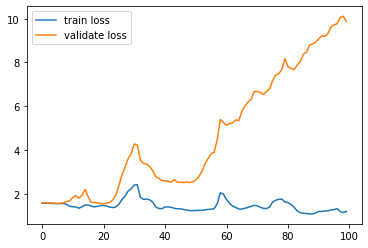

In [27]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

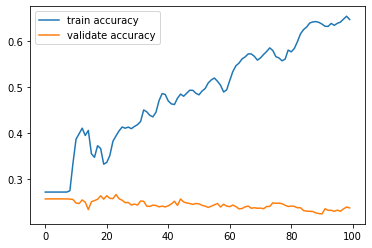

In [28]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Old CNN Color

In [11]:
image_array = np.load("image_array_color.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.25885809, 0.27758399, 0.13273361, 0.25592069, 0.07490362])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 3, 224, 224)

In [16]:
cnn_net = Old_CNN_color(K).float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [17]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 3.6173051130564158
Epoch 0: train accuracy: 0.1262759785562165
Epoch 0: validate loss: 3.615039289643267
Epoch 0: validate accuracy: 0.13273361483385349
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 2.6394800013309445
Epoch 5: train accuracy: 0.2708012043768818
Epoch 5: validate loss: 2.639837019899164
Epoch 5: validate accuracy: 0.2775839911878098
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 2.63813539182351
Epoch 10: train accuracy: 0.2708012043768818
Epoch 10: validate loss: 2.638352445534485
Epoch 10: validate accuracy: 0.2775839911878098
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 2.638136905292114
Epoch 15: train accuracy: 0.2708012043768818
Epoch 15: validate loss: 2.6384172958694774
Epoch 15: validate accuracy: 0.2775839911878098
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 2.638141747271077
Epoch 20: train accuracy: 0.270837923184255
Epoch 20: validate loss: 2.6385090882917797
Epoch 20: validate accuracy: 0.25592069028823206
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 2.6381538078334437
Epoch 25: train accuracy: 0.270837923184255
Epoch 25: validate loss: 2.638608214131666
Epoch 25: validate accuracy: 0.25592069028823206
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 2.638169542706782
Epoch 30: train accuracy: 0.270837923184255
Epoch 30: validate loss: 2.638692350152963
Epoch 30: validate accuracy: 0.25592069028823206
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 2.6381837644967123
Epoch 35: train accuracy: 0.270837923184255
Epoch 35: validate loss: 2.6387512004110647
Epoch 35: validate accuracy: 0.25592069028823206
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 2.638192555816319
Epoch 40: train accuracy: 0.270837923184255
Epoch 40: validate loss: 2.6387855940528673
Epoch 40: validate accuracy: 0.25592069028823206
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 2.638198251651406
Epoch 45: train accuracy: 0.270837923184255
Epoch 45: validate loss: 2.6388051802244936
Epoch 45: validate accuracy: 0.25592069028823206
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 2.638201532450035
Epoch 50: train accuracy: 0.270837923184255
Epoch 50: validate loss: 2.638815517357255
Epoch 50: validate accuracy: 0.25592069028823206
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 2.6382024101707793
Epoch 55: train accuracy: 0.270837923184255
Epoch 55: validate loss: 2.638819986118928
Epoch 55: validate accuracy: 0.25592069028823206
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 2.638203568944254
Epoch 60: train accuracy: 0.270837923184255
Epoch 60: validate loss: 2.6388229105217382
Epoch 60: validate accuracy: 0.25592069028823206
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 2.638203696881726
Epoch 65: train accuracy: 0.270837923184255
Epoch 65: validate loss: 2.638823959484699
Epoch 65: validate accuracy: 0.25592069028823206
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 2.6382039962137394
Epoch 70: train accuracy: 0.270837923184255
Epoch 70: validate loss: 2.6388246531177493
Epoch 70: validate accuracy: 0.25592069028823206
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 2.638204044608316
Epoch 75: train accuracy: 0.270837923184255
Epoch 75: validate loss: 2.638824898233233
Epoch 75: validate accuracy: 0.25592069028823206
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 2.638204124553916
Epoch 80: train accuracy: 0.270837923184255
Epoch 80: validate loss: 2.6388251433487175
Epoch 80: validate accuracy: 0.25592069028823206
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 2.6382041890391643
Epoch 85: train accuracy: 0.270837923184255
Epoch 85: validate loss: 2.638825230889962
Epoch 85: validate accuracy: 0.25592069028823206
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 2.6382041712326214
Epoch 90: train accuracy: 0.270837923184255
Epoch 90: validate loss: 2.6388252921688333
Epoch 90: validate accuracy: 0.25592069028823206
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 2.6382040224070415
Epoch 95: train accuracy: 0.270837923184255
Epoch 95: validate loss: 2.6388250625043783
Epoch 95: validate accuracy: 0.25592069028823206
epoch:  96



epoch:  97



epoch:  98



epoch:  99


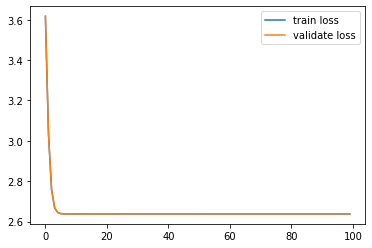

In [18]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

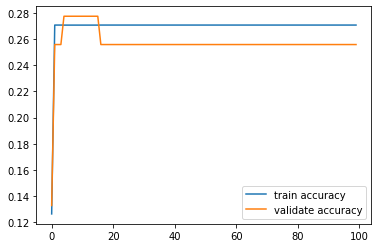

In [19]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Resnet18 Color

In [11]:
image_array = np.load("image_array_color.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.25885809, 0.27758399, 0.13273361, 0.25592069, 0.07490362])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 3, 224, 224)

In [16]:
from torchvision import models

model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, classes)
print(list(model_ft.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

In [17]:
cnn_net = model_ft.float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [18]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.528193870821284
Epoch 0: train accuracy: 0.270837923184255
Epoch 0: validate loss: 1.5452781293027573
Epoch 0: validate accuracy: 0.25592069028823206
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.5075931517468717
Epoch 5: train accuracy: 0.2719762062128222
Epoch 5: validate loss: 1.5203790161748403
Epoch 5: validate accuracy: 0.2562878648797503
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.5058124912304265
Epoch 10: train accuracy: 0.2727840199750312
Epoch 10: validate loss: 1.518393198328104
Epoch 10: validate accuracy: 0.2550027538094364
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.5054697268788506
Epoch 15: train accuracy: 0.2749504296100463
Epoch 15: validate loss: 1.5181475052685613
Epoch 15: validate accuracy: 0.2577565632458234
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.5046894405349862
Epoch 20: train accuracy: 0.2744730851141955
Epoch 20: validate loss: 1.5187559404000244
Epoch 20: validate accuracy: 0.2566550394712686
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.5039368652077054
Epoch 25: train accuracy: 0.27623558786810604
Epoch 25: validate loss: 1.5200792625013
Epoch 25: validate accuracy: 0.25702221406278686
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.503269647399856
Epoch 30: train accuracy: 0.2779246530072703
Epoch 30: validate loss: 1.5220948064220001
Epoch 30: validate accuracy: 0.26197907104828344
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.5032733164669143
Epoch 35: train accuracy: 0.27682308878607625
Epoch 35: validate loss: 1.5235229881614725
Epoch 35: validate accuracy: 0.2583073251331008
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.5101821923506298
Epoch 40: train accuracy: 0.2822207534699273
Epoch 40: validate loss: 1.5364257144078828
Epoch 40: validate accuracy: 0.2540848173306407
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.5143427165531418
Epoch 45: train accuracy: 0.28196372181831536
Epoch 45: validate loss: 1.548801513249576
Epoch 45: validate accuracy: 0.26840462639985313
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.544660366683697
Epoch 50: train accuracy: 0.29330983329661453
Epoch 50: validate loss: 1.6566223131969082
Epoch 50: validate accuracy: 0.2561042775839912
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.5668388137017577
Epoch 55: train accuracy: 0.31581846221634724
Epoch 55: validate loss: 1.7650316232538057
Epoch 55: validate accuracy: 0.25702221406278686
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.4837278413415402
Epoch 60: train accuracy: 0.3035176617463465
Epoch 60: validate loss: 1.5292236213621053
Epoch 60: validate accuracy: 0.26032678538645126
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.4206468470866804
Epoch 65: train accuracy: 0.36674744804288756
Epoch 65: validate loss: 1.5557064546758765
Epoch 65: validate accuracy: 0.2649164677804296
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 1.4475340136979535
Epoch 70: train accuracy: 0.3426231915987369
Epoch 70: validate loss: 1.5506811160351435
Epoch 70: validate accuracy: 0.26014319809069214
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 1.4699364858480104
Epoch 75: train accuracy: 0.331350517735184
Epoch 75: validate loss: 1.5564257250765343
Epoch 75: validate accuracy: 0.25977602349917384
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 1.4343172403616975
Epoch 80: train accuracy: 0.3751193361239627
Epoch 80: validate loss: 1.713120023241738
Epoch 80: validate accuracy: 0.25059665871121717
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 1.071863128462418
Epoch 85: train accuracy: 0.6924432694426085
Epoch 85: validate loss: 3.9364996427392795
Epoch 85: validate accuracy: 0.25702221406278686
epoch:  86



epoch:  87


epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.25422963243526175
Epoch 90: train accuracy: 0.9138576779026217
Epoch 90: validate loss: 3.988678432329436
Epoch 90: validate accuracy: 0.2293005324031577
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.09733273472457557
Epoch 95: train accuracy: 0.9668061981346846
Epoch 95: validate loss: 4.883863828587974
Epoch 95: validate accuracy: 0.24563980172572059
epoch:  96



epoch:  97



epoch:  98



epoch:  99


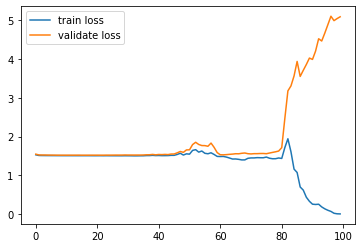

In [19]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

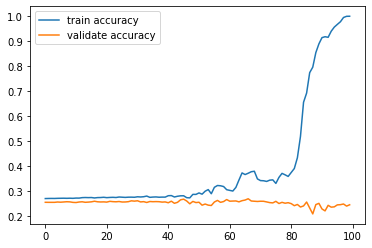

In [20]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()

# Resnet18 bw


In [11]:
image_array = np.load("image_array_bw.npy", mmap_mode = 'r+')

In [12]:
K = len(np.unique(y_train))
np.unique(y_test,return_counts=True)[1]/len(y_test)

array([0.25885809, 0.27758399, 0.13273361, 0.25592069, 0.07490362])

In [13]:
print(str(int(x_id_train[0][0])))
print(str(int(x_id_train[0][0])) in census_id_to_index)

37183053422
True


In [14]:
print(x_id_train.shape)
print(x_id_test.shape)

(27234, 1)
(5447, 1)


In [15]:
image_array.shape

(32681, 4, 224, 224)

In [16]:
from torchvision import models
from torch.nn import Conv2d

model_ft = models.resnet18(pretrained=False)
for param in model_ft.parameters():
    param.requires_grad = True
model_ft.conv1 = Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, classes, bias = True)

In [17]:
cnn_net = model_ft.float().to(device)
optim = torch.optim.Adam(cnn_net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
# 
n_epoches = 100 # To-Do: need more epoches.
batch_size = 200

In [18]:
train_losses, validate_losses, train_accuracies, validate_accuracies = training(x_id_train, y_train, x_id_test, y_test, optimizer=optim, criterion=criterion)

torch.Size([27234])
torch.Size([5447])
Training started: 
epoch:  0



Printing accuracies
Epoch 0: train loss: 1.524116728942615
Epoch 0: train accuracy: 0.2678636997870309
Epoch 0: validate loss: 1.5312610103468163
Epoch 0: validate accuracy: 0.2573893886543051
epoch:  1



epoch:  2



epoch:  3



epoch:  4



epoch:  5



Printing accuracies
Epoch 5: train loss: 1.5077145219225623
Epoch 5: train accuracy: 0.2717558933685834
Epoch 5: validate loss: 1.5207446764997983
Epoch 5: validate accuracy: 0.25683862676702773
epoch:  6



epoch:  7



epoch:  8



epoch:  9



epoch:  10



Printing accuracies
Epoch 10: train loss: 1.5055939211687468
Epoch 10: train accuracy: 0.27322464566350885
Epoch 10: validate loss: 1.5190265515933064
Epoch 10: validate accuracy: 0.2555535156967138
epoch:  11



epoch:  12



epoch:  13



epoch:  14



epoch:  15



Printing accuracies
Epoch 15: train loss: 1.5043807048196003
Epoch 15: train accuracy: 0.2736652713519865
Epoch 15: validate loss: 1.5186263539057074
Epoch 15: validate accuracy: 0.25573710299247293
epoch:  16



epoch:  17



epoch:  18



epoch:  19



epoch:  20



Printing accuracies
Epoch 20: train loss: 1.5025980602130495
Epoch 20: train accuracy: 0.27656605713446425
Epoch 20: validate loss: 1.519537844197431
Epoch 20: validate accuracy: 0.2535340554433633
epoch:  21



epoch:  22



epoch:  23



epoch:  24



epoch:  25



Printing accuracies
Epoch 25: train loss: 1.4999059517670545
Epoch 25: train accuracy: 0.28045825071601677
Epoch 25: validate loss: 1.5231164899773175
Epoch 25: validate accuracy: 0.2551863411051955
epoch:  26



epoch:  27



epoch:  28



epoch:  29



epoch:  30



Printing accuracies
Epoch 30: train loss: 1.4934688788412112
Epoch 30: train accuracy: 0.28769185576852463
Epoch 30: validate loss: 1.5300659476802483
Epoch 30: validate accuracy: 0.254451991922159
epoch:  31



epoch:  32



epoch:  33



epoch:  34



epoch:  35



Printing accuracies
Epoch 35: train loss: 1.4914012901967009
Epoch 35: train accuracy: 0.2921715502680473
Epoch 35: validate loss: 1.5548621602335917
Epoch 35: validate accuracy: 0.26197907104828344
epoch:  36



epoch:  37



epoch:  38



epoch:  39



epoch:  40



Printing accuracies
Epoch 40: train loss: 1.4747047861951157
Epoch 40: train accuracy: 0.30539032092237645
Epoch 40: validate loss: 1.614750954346283
Epoch 40: validate accuracy: 0.25151459519001285
epoch:  41



epoch:  42



epoch:  43



epoch:  44



epoch:  45



Printing accuracies
Epoch 45: train loss: 1.4457943056301545
Epoch 45: train accuracy: 0.32911067048542264
Epoch 45: validate loss: 1.647681192584009
Epoch 45: validate accuracy: 0.26675234073802095
epoch:  46



epoch:  47



epoch:  48



epoch:  49



epoch:  50



Printing accuracies
Epoch 50: train loss: 1.5333252049555222
Epoch 50: train accuracy: 0.36472791363736506
Epoch 50: validate loss: 2.107222253168441
Epoch 50: validate accuracy: 0.2518817697815311
epoch:  51



epoch:  52



epoch:  53



epoch:  54



epoch:  55



Printing accuracies
Epoch 55: train loss: 1.3950249938447632
Epoch 55: train accuracy: 0.4411764705882353
Epoch 55: validate loss: 2.3714997750456144
Epoch 55: validate accuracy: 0.2562878648797503
epoch:  56



epoch:  57



epoch:  58



epoch:  59



epoch:  60



Printing accuracies
Epoch 60: train loss: 1.2696310011372478
Epoch 60: train accuracy: 0.5243812880957627
Epoch 60: validate loss: 2.868397689859255
Epoch 60: validate accuracy: 0.25261611896456765
epoch:  61



epoch:  62



epoch:  63



epoch:  64



epoch:  65



Printing accuracies
Epoch 65: train loss: 1.0490775039549345
Epoch 65: train accuracy: 0.6343541161783065
Epoch 65: validate loss: 3.9134276140408053
Epoch 65: validate accuracy: 0.26087754727372864
epoch:  66



epoch:  67



epoch:  68



epoch:  69



epoch:  70



Printing accuracies
Epoch 70: train loss: 0.7865089433321196
Epoch 70: train accuracy: 0.7212675332305206
Epoch 70: validate loss: 4.485338232944882
Epoch 70: validate accuracy: 0.25169818248577197
epoch:  71



epoch:  72



epoch:  73



epoch:  74



epoch:  75



Printing accuracies
Epoch 75: train loss: 0.4904306901834553
Epoch 75: train accuracy: 0.8108981420283469
Epoch 75: validate loss: 5.118007469860068
Epoch 75: validate accuracy: 0.2533504681476042
epoch:  76



epoch:  77



epoch:  78



epoch:  79



epoch:  80



Printing accuracies
Epoch 80: train loss: 0.37014661544288685
Epoch 80: train accuracy: 0.8556583682162003
Epoch 80: validate loss: 5.531228799524057
Epoch 80: validate accuracy: 0.24802643657058931
epoch:  81



epoch:  82



epoch:  83



epoch:  84



epoch:  85



Printing accuracies
Epoch 85: train loss: 0.2575847700784286
Epoch 85: train accuracy: 0.8960857751340237
Epoch 85: validate loss: 5.899950147659949
Epoch 85: validate accuracy: 0.24710850009179364
epoch:  86



epoch:  87



epoch:  88



epoch:  89



epoch:  90



Printing accuracies
Epoch 90: train loss: 0.2667843994829923
Epoch 90: train accuracy: 0.8963795255930087
Epoch 90: validate loss: 6.554861632666283
Epoch 90: validate accuracy: 0.2522489443730494
epoch:  91



epoch:  92



epoch:  93



epoch:  94



epoch:  95



Printing accuracies
Epoch 95: train loss: 0.17292754766732024
Epoch 95: train accuracy: 0.9305647352573988
Epoch 95: validate loss: 6.602024437988573
Epoch 95: validate accuracy: 0.23994859555718745
epoch:  96



epoch:  97



epoch:  98



epoch:  99


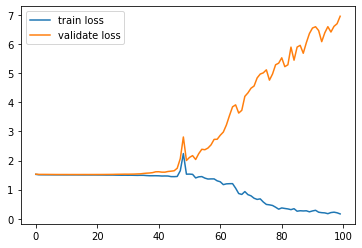

In [19]:
plt.plot(train_losses, label = "train loss")
plt.plot(validate_losses, label = "validate loss")
plt.legend()

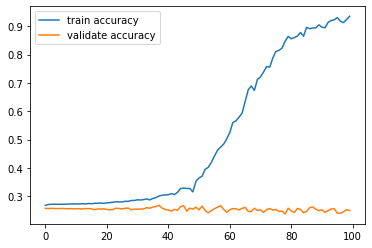

In [20]:
plt.plot(train_accuracies, label = "train accuracy")
plt.plot(validate_accuracies, label = "validate accuracy")
plt.legend()